# Homework2 
Aijia Wang October 8

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
#import data
hf_data = pd.read_excel('proshares_analysis_data.xlsx', sheet_name = 'hedge_fund_series',index_col = 0)
factor_data = pd.read_excel('proshares_analysis_data.xlsx', sheet_name = 'merrill_factors',index_col = 0)
other_data = pd.read_excel('proshares_analysis_data.xlsx', sheet_name = 'other_data',index_col = 0)
other_data['SPY US Equity'] = factor_data['SPY US Equity']

# Question 1: Report statistics
For the series in the “hedge fund series” tab, report the following summary statistics:  
(a) mean  
(b) volatility  
(c) Sharpe ratio  
Annualize these statistics.

In [3]:
def summary_stats(df, annual_fac):
    # report the summary of the input data as a DataFrame
    report = pd.DataFrame()
    report['Mean'] = df.mean() * annual_fac
    report['Vol'] = df.std() * np.sqrt(annual_fac)
    report['Sharpe'] = report['Mean'] / report['Vol']
    return round(report, 4)

In [4]:
summary_stats(hf_data.join(factor_data['SPY US Equity']),12)

,Mean,Vol,Sharpe
HFRIFWI Index,0.0429,0.0609,0.7038
MLEIFCTR Index,0.0257,0.0569,0.4513
MLEIFCTX Index,0.0243,0.0567,0.4283
HDG US Equity,0.0140,0.0592,0.2365
QAI US Equity,0.0116,0.0489,0.2366
SPY US Equity,0.1213,0.1456,0.8327


# Question 2: Tail Risk Statistics
For the series in the “hedge fund series” tab, calculate the following statistics related to tail- risk.  
(a) Skewness  
(b) Excess Kurtosis (in excess of 3)  
(c) VaR (.05) - the fifth quantile of historic returns  
(d) CVaR (.05) - the mean of the returns at or below the fifth quantile  
(e) Maximum drawdown - include the dates of the max/min/recovery within the max drawdown period.  

In [5]:
def tail_risk_report(data, q):
    df = data.copy()
    df.index = data.index.date
    report = pd.DataFrame(columns = df.columns)
    
    report.loc['Skewness'] = df.skew()
    report.loc['Excess Kurtosis'] = df.kurtosis()
    report.loc['VaR'] = df.quantile(q)
    report.loc['Expected Shortfall(CVaR)'] = df[df < df.quantile(q)].mean()
    
    cum_ret = (1 + df).cumprod()
    rolling_max = cum_ret.cummax()
    drawdown = (cum_ret - rolling_max) / rolling_max
    report.loc['Max Drawdown'] = drawdown.min()
    report.loc['MDD Start'] = None
    report.loc['MDD End'] = drawdown.idxmin()
    report.loc['Recovery Date'] = None
    
    for col in df.columns:
        report.loc['MDD Start', col] = (rolling_max.loc[:report.loc['MDD End', col]])[col].idxmax()
        recovery_df = (drawdown.loc[report.loc['MDD End', col]:])[col]
        # modify the threshold for recovery from 0 to 0.001
        try:
            report.loc['Recovery Date', col] = recovery_df[recovery_df >= 0].index[0]
            report.loc['Recovery period (days)'] = (report.loc['Recovery Date'] - report.loc['MDD Start']).dt.days

        except:
            report.loc['Recovery Date', col] = None
            report.loc['Recovery period (days)',col] = None

    return round(report,4)

In [6]:
tail_risk_report(hf_data.join(factor_data['SPY US Equity']),0.05)

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity,SPY US Equity
Skewness,-1.020683,-0.315513,-0.304807,-0.298573,-0.634129,-0.413602
Excess Kurtosis,6.163102,1.778696,1.741807,1.931106,1.913339,0.936671
VaR,-0.025585,-0.029652,-0.029867,-0.031528,-0.021245,-0.069215
Expected Shortfall(CVaR),-0.039205,-0.036865,-0.036763,-0.038482,-0.034401,-0.089169
Max Drawdown,-0.115473,-0.124302,-0.124388,-0.14072,-0.137714,-0.239271
MDD Start,2019-12-31,2021-06-30,2021-06-30,2021-06-30,2021-06-30,2021-12-31
MDD End,2020-03-31,2022-09-30,2022-09-30,2022-09-30,2022-09-30,2022-09-30
Recovery Date,2020-08-31,None,None,None,None,None
Recovery period (days),244.0,None,None,None,None,None


# Question 3: Regression-based statistics  

For the series in the “hedge fund series” tab, run a regression of each against SPY (found in the “merrill factors” tab.) Include an intercept. Report the following regression-based statistics:  
(a) Market Beta  
(b) Treynor Ratio  
(c) Information ratio  
Annualize these three statistics as appropriate.

In [7]:
def reg_stats(df, annual_fac):
    reg_stats = pd.DataFrame(data = None, index = df.columns, columns = ['beta', 
                                                                         'Treynor Ratio', 
                                                                'Information Ratio'])
    for col in df.columns:
        # Drop the NAs in y
        y = df[col].dropna()
        # Align the X with y 
        X = sm.add_constant(factor_data['SPY US Equity'].loc[y.index])
        reg = sm.OLS(y, X).fit()
        reg_stats.loc[col, 'beta'] = reg.params[1]
        reg_stats.loc[col, 'Treynor Ratio'] = (df[col].mean() * annual_fac) / reg.params[1]
        reg_stats.loc[col, 'Information Ratio'] = (reg.params[0] / reg.resid.std()) * np.sqrt(annual_fac)
      
    return reg_stats.astype(float).round(4)
reg_stats(hf_data,12)

,beta,Treynor Ratio,Information Ratio
HFRIFWI Index,0.3500,0.1225,0.0130
MLEIFCTR Index,0.3549,0.0723,-0.7315
MLEIFCTX Index,0.3536,0.0687,-0.7846
HDG US Equity,0.3631,0.0386,-1.1237
QAI US Equity,0.2919,0.0397,-0.9838


# Queation 4: Relative Performance
Discuss the previous statistics, and what they tell us about...  
### (a) Differences between SPY and the hedge-fund series?

The SPY has a higher mean, volatility and Sharpe Ratio.

The SPY has more tail risks as it has smaller VaR, and CVaR, meaning that all hedge fund chosed to be more prudent this year. Besides, all hedge-fund series except **HFRIFWI** have a negative information ratio, which indicates that they fail to beat the market, while **HFRIFWI** beat the market.

### (b) Which performs better between HDG and QAI.

Although HDG has a slightly higher mean return, it also has a higher volatility, so they have almost the same Sharpe Ratio (QAI slightly higher).

In addition, HDG contains more tail risks as it has smaller VaR, CVaR, and Maximum Drawdown.

QAI is also less correlated to the market(See the heat map below), and has a slightly higher Treynor Ratio and Information Ratio. Therefore, **QAI performs better than HDG.**

### (c) Whether HDG and the ML series capture the most notable properties of HFRI.

Both HDG and the ML series fail to deliver the same high returns compensated with the high risk of HRFI.  
The HFRI has an excess kurtosis higher than those of ML and HDG, and a skewness lower than those of ML and HDG.  
So HDG and the ML series can't replicate(capture) the properties of HFRI.

# Question 5: Correlation Matrix  
(a) Show the correlations as a heat map.  

In [8]:
#display corrolation as a heatmap
def display_correlation(df,list_maxmin=True):
    
    corrmat = df.corr()
    #ignore self-correlation
    
    # heatmap of the correlation
    fig1 = plt.subplots(figsize=(10,8) ) 
    fig1 = sns.heatmap(corrmat, cmap='Blues', annot=True) 
    fig1.set_title('Correlation Matrix',fontsize = 13) 
    plt.show()
    
### Make the diagonals NaN so we can find the highest and lowest pairwise correlations
    corrmat[corrmat==1] = None

    if list_maxmin:
        corr_rank = corrmat.unstack().sort_values().dropna()
        pair_max = corr_rank.index[-1]
        pair_min = corr_rank.index[0]

        print(f'MIN Correlation pair is {pair_min}')
        print(f'MAX Correlation pair is {pair_max}')

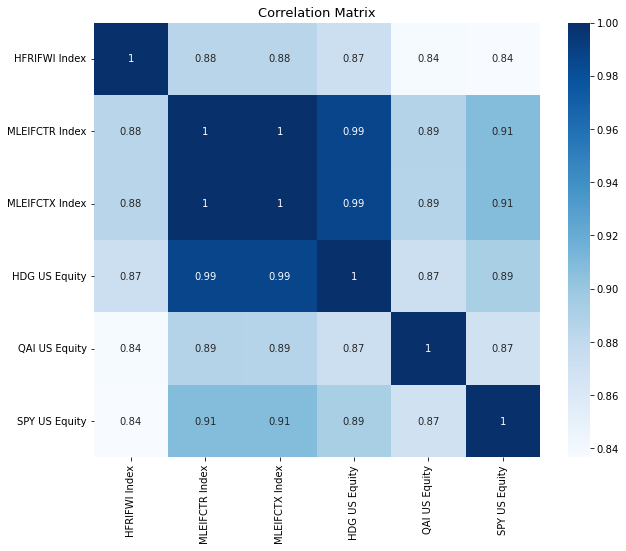

MIN Correlation pair is ('HFRIFWI Index', 'SPY US Equity')
MAX Correlation pair is ('MLEIFCTR Index', 'MLEIFCTX Index')


In [9]:
display_correlation(hf_data.join(factor_data['SPY US Equity']),True)

(b) Which series have the highest and lowest correlations?  

As is shown below, MLEIFCTX Index and MLEIFCTR Index has highest correlation;  

HFRIFWI Index, SPY US Equity has lowest correlation.

# Question 6: Replicate HFRI  
Replicate HFRI with the six factors listed on the “merrill factors” tab. Include a constant, and run the unrestricted regression  

In [10]:
y = hf_data['HFRIFWI Index']
X = sm.add_constant(factor_data)
static_model = sm.OLS(y,X).fit()

## (a) Intercept and beta

In [11]:
static_model.params.to_frame('Regression Parameters')

,Regression Parameters
const,0.001142
SPY US Equity,0.025589
USGG3M Index,0.834569
EEM US Equity,0.074135
EFA US Equity,0.105604
EUO US Equity,0.023240
IWM US Equity,0.147375


## (b) Are the betas realistic position sizes, or do they require huge long-short positions?  
The betas look like realistic position sizes. They do not require huge long-short positions.

## (c) Report the R-squared.

In [12]:
round(static_model.rsquared,4)

0.8213

## (d) Report the volatility of $\epsilon^{merr}$, (the tracking error.)

In [13]:
round(static_model.resid.std() * np.sqrt(12),4)

0.0258

# Queation 7: Let's examine the replication out-of-sample.  
## Estimates of regression parameters

In [14]:
model = RollingOLS(y,X,window=60)
rolling_betas = model.fit().params.copy()
rolling_betas

,const,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
2011-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2022-05-31,0.004084,0.014981,-2.033076,0.108451,0.115181,0.033973,0.175357
2022-06-30,0.004204,0.011314,-2.009264,0.106422,0.111324,0.028605,0.181174
2022-07-31,0.004532,0.001035,-2.399443,0.118317,0.107350,0.020165,0.176503
2022-08-31,0.004210,-0.001067,-1.796845,0.128498,0.076688,0.018624,0.189947


In [15]:
rep_IS = (rolling_betas * X).sum(axis=1,skipna=False)
# first-order derivative
rep_OOS = (rolling_betas.shift() * X).sum(axis=1,skipna=False)
replication = hf_data[['HFRIFWI Index']].copy()
replication['Static-IS-Int'] = static_model.fittedvalues
replication['Rolling-IS-Int'] = rep_IS
replication['Rolling-OOS-Int'] = rep_OOS

In [16]:
replication.corr()

,HFRIFWI Index,Static-IS-Int,Rolling-IS-Int,Rolling-OOS-Int
HFRIFWI Index,1.000000,0.906244,0.930242,0.887358
Static-IS-Int,0.906244,1.000000,0.990015,0.986613
Rolling-IS-Int,0.930242,0.990015,1.000000,0.993332
Rolling-OOS-Int,0.887358,0.986613,0.993332,1.000000


<AxesSubplot:>

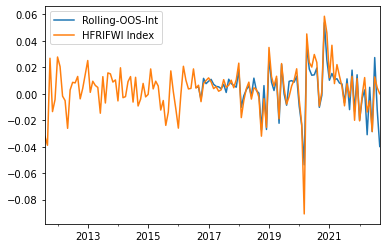

In [17]:
replication[['Rolling-OOS-Int','HFRIFWI Index']].plot()

## Out-of-sample replication perform
The out-of-sample replication performs very well with respect to the target. It has a very high correlation to the HFRI.

# Question 8.
We estimated the replications using an intercept. Try the full-sample estimation, but this time without an intercept.

In [18]:
y = hf_data['HFRIFWI Index']
X = factor_data
static_model_noint = sm.OLS(y,X).fit()

## (a)  Report the regression beta. How does it compare to the estimated beta with an intercept, $\hat{\beta}^{merr}$?  

Without an intercept, the betas are almost identical, except the beta in the **3-month T-bills**.  

Becasue T-bills have **low volatility**, they act like an intercept. Thus, the regression performance is very similar.

In [19]:
betas = pd.DataFrame(static_model.params,columns=['Yes Intercept']).T
betas.loc['No Intercept'] = static_model_noint.params
betas

,const,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
Yes Intercept,0.001142,0.025589,0.834569,0.074135,0.105604,0.023240,0.147375
No Intercept,NaN,0.040448,1.551706,0.073052,0.100760,0.024909,0.144352


## (b) Mean of the fitted value, $\check{r}_t^{hfri}$  
The mean of the fitted value $\check{r}_t^{hfri}$ is **smaller** than the mean of the HFRI

In [20]:
print("The mean of the fitted value is", round(static_model_noint.fittedvalues.mean(),4)*12)

The mean of the fitted value is 0.0348


In [21]:
print("The mean of the HFRI is",round(hf_data['HFRIFWI Index'].mean(),4)*12)

The mean of the HFRI is 0.0432


## (c) Correlations of the fitted values,$\check{r}_t^{hfri}$  
 
The correlations of the fitted values of model without an intercept to the HFRI are **high**.(corr=0.905696)

This correlation are very similar to that of the fitted values of the model with an intercept.(corr=0.906244)

In [22]:
replication['Static-IS-NoInt'] = static_model_noint.fittedvalues
replication.corr()

,HFRIFWI Index,Static-IS-Int,Rolling-IS-Int,Rolling-OOS-Int,Static-IS-NoInt
HFRIFWI Index,1.000000,0.906244,0.930242,0.887358,0.905696
Static-IS-Int,0.906244,1.000000,0.990015,0.986613,0.999395
Rolling-IS-Int,0.930242,0.990015,1.000000,0.993332,0.987919
Rolling-OOS-Int,0.887358,0.986613,0.993332,1.000000,0.984103
Static-IS-NoInt,0.905696,0.999395,0.987919,0.984103,1.000000


## Do you think Merrill and ProShares fit their replicators with an intercept or not? 
If we want construct an ETF to replicate hedge-fund returns (including behaviors like mean and SR), then we should not include an intercept in the regression.

If we want to construct a hedge or a similar variation, then we should include an intercept. As a result, the portfolio we construct will have lower mean and matched variance.

In general, we desire higher mean return, thus we **should not include intercept.**